# Possible Cases:
`Note: Since we're dealing with superstore and not e-commerce, we're better of with the second option than the first(since, it's kinda hard to maintain personal data and give personalised recommendations for users at a superstore.)`

1. General Recommendations for users, based on past user purchases.
2. Recommendations based on what the user is buying, like if someone were to buy bread then they're likely to buy butter along with it too. i.e., recommend items that are frequently bought together.

# Uncomment and run the below cell if using colab, to acces files from the drive.

In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and other configurations

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
import warnings
import os
import time
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.style.use("ggplot")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# a function to get the path of the dataset from the user
def get_dataset_path():
    dataset_path = input("Please enter the path to your dataset: ")
    while not os.path.exists(dataset_path):
        print("The path does not exist. Please enter a valid path.")
        dataset_path = input("Please enter the path to your dataset: ")
    return dataset_path

In [4]:
ds = pd.read_csv(get_dataset_path(), encoding='ISO-8859-1')
df = ds.dropna()
print(df.shape)
df.head()

Please enter the path to your dataset: /content/drive/MyDrive/data mining project/OnlineRetail.csv
(406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Preprocessing

In [5]:
# let's get a brief overview of the dataset
def df_info(dataframe):
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

df_info(df)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB
None
##################### NA #####################
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
##################### Quantiles #####################
               count          mean          std      min       0%        5%  \
Quantity    40

In [6]:
# calculate the outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
Quantity,406829.0,10.909092,175.073448,-80995.0,-80995.0,1.00,5.00,36.0,120.0,303.000,303.000
UnitPrice,406829.0,2.934619,3.333789,0.0,0.0,0.42,1.95,8.5,15.0,37.185,37.185
CustomerID,406829.0,15287.690570,1713.600303,12346.0,12346.0,12626.00,15152.00,17905.0,18212.0,18287.000,18287.000


In [7]:
df["Description"] = df["Description"].str.strip(" ")
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["StockCode"].apply(lambda x: str(x).isnumeric())]
df = df[df["Quantity"] > 0]

<ipython-input-7-2f459e34233d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Description"] = df["Description"].str.strip(" ")


# Data Transformation

In [8]:
# transforming the dataset to get the data about each individual transaction

basket = (df[df["Country"] == "Germany"]
              .groupby(["InvoiceNo", "Description"])["Quantity"]
              .sum().unstack().fillna(0)
              .applymap(lambda x: 1 if x > 0 else 0))
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YOU'RE CONFUSING ME METAL SIGN,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Pattern Mining and Evaluation

## Apriori

In [22]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

start_time = time.time()
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
apriori_time = time.time()-start_time
frequent_itemsets.head()

,support,itemsets
0,0.024943,(10 COLOUR SPACEBOY PEN)
1,0.022676,(12 PENCIL SMALL TUBE WOODLAND)
2,0.020408,(12 PENCILS TALL TUBE WOODLAND)
3,0.034014,(3 HOOK HANGER MAGIC GARDEN)
4,0.043084,(3 PIECE SPACEBOY COOKIE CUTTER SET)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

192


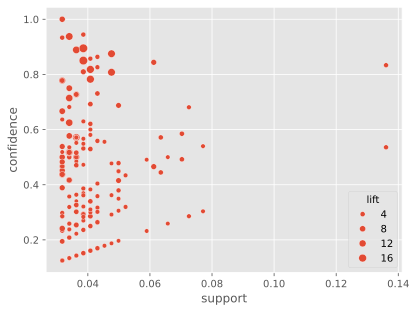

In [10]:
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.03)
sns.scatterplot(x = "support", y = "confidence",
                size = "lift", data = rules)
print(len(rules))
plt.show()

In [12]:
# filter the rules to select a few significant rules
filtered_rules = rules[
                      (rules['support'] > 0.01) &
                      (rules['confidence'] > 0.5)
                    ]
sorted_rules = filtered_rules.sort_values(by='confidence', ascending=False)
print(len(sorted_rules))
sorted_rules

62


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
174,"(ROUND SNACK BOXES SET OF4 WOODLAND, RED RETRO...",(WOODLAND CHARLOTTE BAG),0.031746,0.131519,0.031746,1.000000,7.603448,0.027571,inf,0.896956
182,"(SPACEBOY LUNCH BOX, ROUND SNACK BOXES SET OF ...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.040816,0.253968,0.038549,0.944444,3.718750,0.028183,13.428571,0.762203
27,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.036281,0.065760,0.034014,0.937500,14.256466,0.031628,14.947846,0.964863
139,"(CHARLOTTE BAG APPLES DESIGN, ROUND SNACK BOXE...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.034014,0.253968,0.031746,0.933333,3.675000,0.023108,11.190476,0.753521
134,(SPACEBOY CHILDRENS BOWL),(SPACEBOY CHILDRENS CUP),0.043084,0.045351,0.038549,0.894737,19.728947,0.036595,9.069161,0.992055
...,...,...,...,...,...,...,...,...,...,...
26,(JAM JAR WITH PINK LID),(JAM JAR WITH GREEN LID),0.065760,0.036281,0.034014,0.517241,14.256466,0.031628,1.996275,0.995307
44,(LUNCH BOX WITH CUTLERY RETROSPOT),(ROUND SNACK BOXES SET OF 4 FRUITS),0.065760,0.163265,0.034014,0.517241,3.168103,0.023277,1.733236,0.732524
50,(LUNCH BOX WITH CUTLERY RETROSPOT),(STRAWBERRY LUNCH BOX WITH CUTLERY),0.065760,0.081633,0.034014,0.517241,6.336207,0.028645,1.902332,0.901456
48,(LUNCH BOX WITH CUTLERY RETROSPOT),(SKULL LUNCH BOX WITH CUTLERY),0.065760,0.058957,0.034014,0.517241,8.773210,0.030137,1.949304,0.948382


## FP Growth

In [23]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

start_time = time.time()
frequent_itemsets_fpg = fpgrowth(basket, min_support=0.02, use_colnames=True)
fpg_time = time.time() - start_time
frequent_itemsets_fpg.head()

,support,itemsets
0,0.104308,(JUMBO BAG WOODLAND ANIMALS)
1,0.038549,(5 HOOK HANGER RED MAGIC TOADSTOOL)
2,0.034014,(3 HOOK HANGER MAGIC GARDEN)
3,0.031746,(CHILDREN'S CIRCUS PARADE MUG)
4,0.027211,(JUMBO BAG OWLS)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

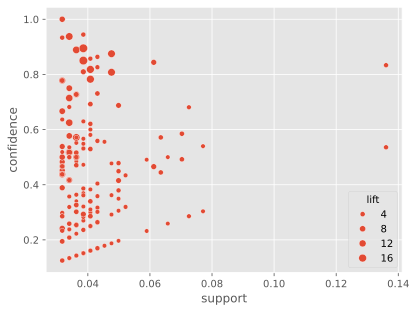

In [14]:
rules_fpg = association_rules(frequent_itemsets_fpg, metric="support", min_threshold=0.03)
sns.scatterplot(x = "support", y = "confidence",
                size = "lift", data = rules_fpg)
plt.show()

In [20]:
# filter the rules to select a few significant rules
filtered_rules_fpg = rules_fpg[
                              (rules_fpg['support'] > 0.01) &
                              (rules_fpg['confidence'] > 0.5)
                            ]
sorted_rules_fpg = filtered_rules_fpg.sort_values(by='confidence', ascending=False)
print(len(sorted_rules_fpg))
sorted_rules_fpg

62


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
72,"(ROUND SNACK BOXES SET OF4 WOODLAND, RED RETRO...",(WOODLAND CHARLOTTE BAG),0.031746,0.131519,0.031746,1.000000,7.603448,0.027571,inf,0.896956
62,"(SPACEBOY LUNCH BOX, ROUND SNACK BOXES SET OF ...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.040816,0.253968,0.038549,0.944444,3.718750,0.028183,13.428571,0.762203
13,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.036281,0.065760,0.034014,0.937500,14.256466,0.031628,14.947846,0.964863
181,"(CHARLOTTE BAG APPLES DESIGN, ROUND SNACK BOXE...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.034014,0.253968,0.031746,0.933333,3.675000,0.023108,11.190476,0.753521
190,(SPACEBOY CHILDRENS BOWL),(SPACEBOY CHILDRENS CUP),0.043084,0.045351,0.038549,0.894737,19.728947,0.036595,9.069161,0.992055
...,...,...,...,...,...,...,...,...,...,...
158,(LUNCH BOX WITH CUTLERY RETROSPOT),(SKULL LUNCH BOX WITH CUTLERY),0.065760,0.058957,0.034014,0.517241,8.773210,0.030137,1.949304,0.948382
134,(LUNCH BOX WITH CUTLERY RETROSPOT),(STRAWBERRY LUNCH BOX WITH CUTLERY),0.065760,0.081633,0.034014,0.517241,6.336207,0.028645,1.902332,0.901456
136,(LUNCH BOX WITH CUTLERY RETROSPOT),(ROUND SNACK BOXES SET OF 4 FRUITS),0.065760,0.163265,0.034014,0.517241,3.168103,0.023277,1.733236,0.732524
12,(JAM JAR WITH PINK LID),(JAM JAR WITH GREEN LID),0.065760,0.036281,0.034014,0.517241,14.256466,0.031628,1.996275,0.995307


# Performance Comparison

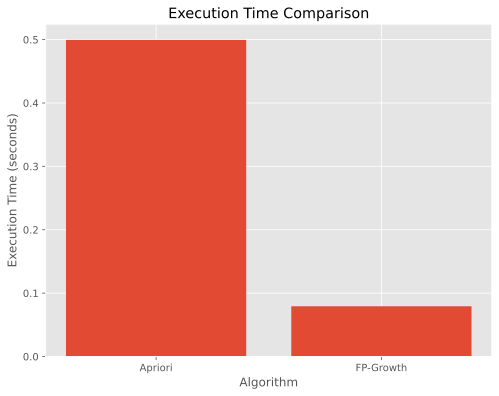

In [24]:
algorithms = ['Apriori', 'FP-Growth']
execution_times = [apriori_time, fpg_time]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, execution_times)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.show()

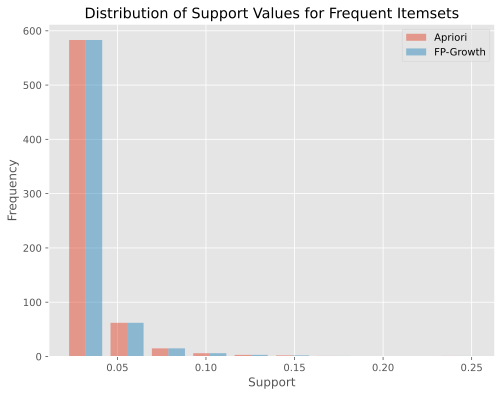

In [25]:
plt.figure(figsize=(8, 6))
plt.hist([frequent_itemsets['support'], frequent_itemsets_fpg['support']], alpha=0.5, label=['Apriori', 'FP-Growth'])
plt.legend(loc='upper right')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.title('Distribution of Support Values for Frequent Itemsets')
plt.show()

# Recommendation:
* Now, to recommend products to a customer, check the products in their cart, and reccomend products based on association rules.

In [16]:
# a function to recommend products based on the contents of cart of a user
def get_cart_recommendations(current_cart, filtered_rules):
  recommendations = set()
  for item, value in current_cart.items():
    filtered_rules = sorted_rules[sorted_rules['antecedents'].apply(lambda x: item in x)]
    for _, rule in filtered_rules.iterrows():
            recommendations.update(rule['consequents'])
  return recommendations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exports
* Export the mined rules as json objects to use in website

In [17]:
import json

# Convert association rules to JSON serializable format
json_data = []
for index, rule in sorted_rules.iterrows():
    json_rule = {
        'antecedents': list(rule['antecedents']),
        'consequents': list(rule['consequents']),
        'support': rule['support'],
        'confidence': rule['confidence'],
        'lift': rule['lift']
        # Add more metrics as needed
    }
    json_data.append(json_rule)

# Write JSON data to a file
output_file_path = '/content/drive/MyDrive/data mining project/association_rules.json'
with open(output_file_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print(f"Association rules have been written to {output_file_path}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Association rules have been written to /content/drive/MyDrive/data mining project/association_rules.json


In [18]:
# to select only the products involved in significant rules.
products = set()
for index, rule in sorted_rules.iterrows():
  products.update(rule['antecedents'])
  products.update(rule['consequents'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [19]:
import random
json_data = []
pid = 0
for product in products:
  price = round(random.uniform(1.0, 100.0), 2)
  json_product = {
      "id": pid,
      "name": product,
      "price": price
  }
  json_data.append(json_product)
  pid = pid+1

output_file_path = '/content/drive/MyDrive/data mining project/products.json'
with open(output_file_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)

print(f"products have been saved to {output_file_path}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


products have been saved to /content/drive/MyDrive/data mining project/products.json
